# Notebook 3.1 -- Shallow neural networks I

The purpose of this notebook is to gain some familiarity with shallow neural networks with 1D inputs. It works through an example similar to figure 3.3 and experiments with different activation functions.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and write code to complete the functions. There are also questions interspersed in the text.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# import a bunch of mojo things to help with math computation

from benchmark import Unit, run
from math import iota
from math import ceil
from math import select
from math import pow
from python import Python
from python.object import PythonObject
from runtime.llcl import num_cores
from algorithm import parallelize, vectorize, vectorize_unroll
from tensor import Tensor, TensorShape
from utils.index import Index

alias float_type = DType.float32
alias simd_width = simdwidthof[float_type]()

In [2]:
%%python
# Imports math library
# import numpy as np
# Imports plotting library
# import matplotlib.pyplot as plt

from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")

In [3]:
# Define the Rectified Linear Unit (ReLU) function

def ReLU[T: DType, width: Int](preactivation: SIMD[T, width]) -> SIMD[T, width]:
    # TODO write code to implement the ReLU and compute the activation at the
    # hidden unit from the preactivation
    # This should work on every element of the ndarray "preactivation" at once
    # One way to do this is with the ndarray "clip" function
    # https://numpy.org/doc/stable/reference/generated/numpy.ndarray.clip.html
    # activation = np.zeros_like(preactivation);
    let is_zero = preactivation < 0
    let zeros = SIMD[T, width]()
    return select(is_zero, zeros, preactivation)

def ReLU[T: DType, width: Int](preactivation: Tensor[T]) -> Tensor[T]:
    let original_shape = preactivation.shape()
    let num_elements = preactivation.num_elements()

    preactivation.reshape(TensorShape(num_elements))
    relu = Tensor[T](TensorShape(num_elements))

    @parameter
    fn compute[width: Int](col: Int):
        let preactivation_data = preactivation.data().simd_load[width](col)
        let is_zero = preactivation_data < 0
        let zeros = SIMD[T, width]()
        
        relu.data().simd_store[width](col, select(is_zero, zeros, preactivation_data))
    
    vectorize[width, compute](num_elements)

    preactivation.reshape(original_shape)
    relu.reshape(original_shape)
    return relu

In [4]:
let z = SIMD[float_type, simd_width](-5, 5, 0, -2)
print(ReLU(z))

let z1 = Tensor[float_type](TensorShape(3,4), 0, 1, 2, 3, 4, 5, 6, -1, -2, -3, -4, -5)
print(ReLU[float_type, simd_width](z1))

[0.0, 5.0, 0.0, 0.0]
Tensor([[0.0, 1.0, 2.0, 3.0],
[4.0, 5.0, 6.0, 0.0],
[0.0, 0.0, 0.0, 0.0]], dtype=float32, shape=3x4)


In [5]:
# Bring in my trusty linear init function
fn linear_init[T: DType](start: SIMD[T,1] = 0, end: SIMD[T,1] = 1, step: SIMD[T,1] = 1) -> Tensor[T]:
    from math import ceil
    let length = ceil((end-start)/step).to_int()
    var t = Tensor[T](length)
    var v = start
    for i in range(length):
        t[i] = v
        v = v + step

    return t

In [6]:
let z = linear_init[float_type](-5, 5, 0.1)
ReLU_z = ReLU[float_type, simd_width](z)

In [7]:
# helper function to convert Tensor to numpy
# very inefficient, is there a better way to do this?

def to_numpy[T: DType](x: Tensor[T]) -> PythonObject:
    let np = Python.import_module("numpy")
    let shape = x.shape()
    let np_shape = Python.evaluate("list()")
    var num_elems = 1
    let data = x.data()

    for index in range(shape.rank()):
        let len = shape[index]
        np_shape.append(len)
        num_elems = num_elems * shape[index]
        

    let numpy = np.zeros((num_elems))
    let reshaped = x.reshape(TensorShape(num_elems))

    for i in range(num_elems):
        numpy.itemset((i), reshaped[i])

    return numpy.reshape(np_shape)

# Function to help plot the data
def linplot[T: DType](x: Tensor[T], y: Tensor[T]):

    # import the required python modules
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")
    let colors = Python.import_module("matplotlib.colors")

    fig_ax = plt.subplots()
    fig = fig_ax[0]
    ax = fig_ax[1]

    # convert the tensors to numpy
    xnp = to_numpy(x)
    ynp = to_numpy(y)

    ax.plot(xnp,ynp, 'r-')
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')
    ax.set_aspect('equal')


    plt.show()

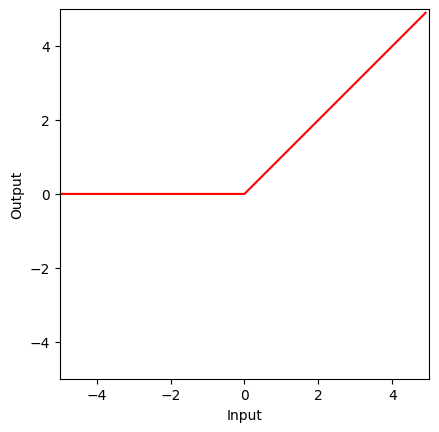

In [8]:
linplot(z, ReLU_z)

In [9]:
# Define a shallow neural network with, one input, one output, and three hidden units
fn shallow_1_1_3_full[T: DType, width: Int](
    x: Tensor[T], 
    phi_0: SIMD[T, 1], phi_1: SIMD[T, 1], phi_2: SIMD[T, 1], phi_3: SIMD[T, 1],
    theta_10: SIMD[T,1], theta_11: SIMD[T,1], 
    theta_20: SIMD[T,1], theta_21: SIMD[T,1], 
    theta_30: SIMD[T,1], theta_31: SIMD[T,1]) raises -> Tensor[T]:

  let num = x.num_elements()
  var Y = Tensor[T](TensorShape(10, num))
  
  # TODO Replace the lines below to compute the three initial lines
  # (figure 3.3a-c) from the theta parameters.  These are the preactivations
  let pre_1 = theta_10 + theta_11 * x
  let pre_2 = theta_20 + theta_21 * x
  let pre_3 = theta_30 + theta_31 * x

  # Pass these through the ReLU function to compute the activations as in
  # figure 3.3 d-f
  let act_1 = ReLU[T, width](pre_1)
  let act_2 = ReLU[T, width](pre_2)
  let act_3 = ReLU[T, width](pre_3)

  # TODO Replace the code below to weight the activations using phi1, phi2 and phi3
  # To create the equivalent of figure 3.3 g-i
  let w_act_1 = act_1 * phi_1
  let w_act_2 = act_2 * phi_2
  let w_act_3 = act_3 * phi_3

  # TODO Replace the code below to combining the weighted activations and add
  # phi_0 to create the output as in figure 3.3 j
  let y = w_act_1 + w_act_2 + w_act_3 + phi_0

  # Return everything we have calculated
  for i in range(num):
    Y[Index(0, i)] = y[i]
    Y[Index(1, i)] = pre_1[i]
    Y[Index(2, i)] = pre_2[i]
    Y[Index(3, i)] = pre_3[i]
    Y[Index(4, i)] = act_1[i]
    Y[Index(5, i)] = act_2[i]
    Y[Index(6, i)] = act_3[i]
    Y[Index(7, i)] = w_act_1[i]
    Y[Index(8, i)] = w_act_2[i]
    Y[Index(9, i)] = w_act_3[i]

  return Y

In [10]:
let tiny = linear_init[float_type](0, 1, 0.01)
let theta_10: SIMD[float_type, 1] =  0.3
let theta_11: SIMD[float_type, 1] = -1.0
let theta_20: SIMD[float_type, 1] = -1.0
let theta_21: SIMD[float_type, 1] = 2.0
let theta_30: SIMD[float_type, 1] = -0.5
let theta_31: SIMD[float_type, 1] = 0.65
let phi_0: SIMD[float_type, 1] = -0.3
let phi_1: SIMD[float_type, 1] = 2.0
let phi_2: SIMD[float_type, 1] = -1.0
let phi_3: SIMD[float_type, 1] = 7.0
let tiny_net = shallow_1_1_3_full[float_type, simd_width](tiny, 
                             phi_0, phi_1, phi_2, phi_3, 
                             theta_10, theta_11, 
                             theta_20, theta_21,
                             theta_30, theta_31)
print(tiny_net)

Tensor([[0.30000001192092896, 0.28000003099441528, 0.25999999046325684, ..., -0.32650196552276611, -0.3010019063949585, -0.27550190687179565],
[0.30000001192092896, 0.29000002145767212, 0.2800000011920929, ..., -0.66999936103820801, -0.67999935150146484, -0.68999934196472168],
[-1.0, -0.98000001907348633, -0.95999997854232788, ..., 0.93999874591827393, 0.9599987268447876, 0.97999870777130127],
..., 
[0.60000002384185791, 0.58000004291534424, 0.56000000238418579, ..., 0.0, 0.0, 0.0],
[-0.0, -0.0, -0.0, ..., -0.93999874591827393, -0.9599987268447876, -0.97999870777130127],
[0.0, 0.0, 0.0, ..., 0.91349679231643677, 0.95899683237075806, 1.0044968128204346]], dtype=float32, shape=10x100)


In [11]:
# Plot the shallow neural network.  We'll assume input in is range [0,1] and output [-1,1]
# If the plot_all flag is set to true, then we'll plot all the intermediate stages as in Figure 3.3
def plot_neural[T: DType](x: Tensor[T], Y: Tensor[T],
                          plot_all=False,
                          x_data: Tensor[T] = Tensor[T](1), y_data: Tensor[T] = Tensor[T](1),
                          plot_data=False):
    # import the required python modules
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")
    let colors = Python.import_module("matplotlib.colors")

    print("imported")

    # unpack the input
    cols = Y.shape()[1]
    var y = Tensor[T](TensorShape(cols))
    var pre_1 = Tensor[T](TensorShape(cols))
    var pre_2 = Tensor[T](TensorShape(cols))
    var pre_3 = Tensor[T](TensorShape(cols))
    var act_1 = Tensor[T](TensorShape(cols))
    var act_2 = Tensor[T](TensorShape(cols))
    var act_3 = Tensor[T](TensorShape(cols))
    var w_act_1 = Tensor[T](TensorShape(cols))
    var w_act_2 = Tensor[T](TensorShape(cols))
    var w_act_3 = Tensor[T](TensorShape(cols))

    for i in range(cols):
        y[Index(i)] = Y[Index(0, i)]
        pre_1[Index(i)] =Y[Index(1, i)]
        pre_2[Index(i)] = Y[Index(2, i)] 
        pre_3[Index(i)] = Y[Index(3, i)]
        act_1[Index(i)] = Y[Index(4, i)]
        act_2[Index(i)] = Y[Index(5, i)]
        act_3[Index(i)] = Y[Index(6, i)]
        w_act_1[Index(i)] = Y[Index(7, i)]
        w_act_2[Index(i)] = Y[Index(8, i)]
        w_act_3[Index(i)] = Y[Index(9, i)]

    let xn = to_numpy[T](x)
    let yn = to_numpy[T](y)
    let pre_1n = to_numpy[T](pre_1)
    let pre_2n = to_numpy(pre_2)
    let pre_3n = to_numpy(pre_3)
    let act_1n = to_numpy(act_1)
    let act_2n = to_numpy(act_2)
    let act_3n = to_numpy(act_3)
    let w_act_1n = to_numpy(w_act_1)
    let w_act_2n = to_numpy(w_act_2)
    let w_act_3n = to_numpy(w_act_3)


    # Plot intermediate plots if flag set
    if plot_all:
        fig_ax = plt.subplots(3,3)
        fig = fig_ax[0]
        ax = fig_ax[1]

        fig.set_visible(False)
        fig.set_size_inches(8.5, 8.49)

        #fig.tight_layout(pad=3.0)
        ax.item((0,0)).plot(xn,pre_1n,'r-')
        ax.item((0,0)).set_ylabel('Preactivation')
        ax.item((0,1)).plot(xn,pre_2n,'b-')
        ax.item((0,1)).set_ylabel('Preactivation')
        ax.item((0,2)).plot(xn,pre_3n,'g-')
        ax.item((0,2)).set_ylabel('Preactivation')
        ax.item((1,0)).plot(xn,act_1n,'r-')
        ax.item((1,0)).set_ylabel('Activation')
        ax.item((1,1)).plot(xn,act_2n,'b-')
        ax.item((1,1)).set_ylabel('Activation')
        ax.item((1,2)).plot(xn,act_3n,'g-')
        ax.item((1,2)).set_ylabel('Activation')
        ax.item((2,0)).plot(xn,w_act_1n,'r-')
        ax.item((2,0)).set_ylabel('Weighted Act')
        ax.item((2,1)).plot(xn,w_act_2n,'b-')
        ax.item((2,1)).set_ylabel('Weighted Act')
        ax.item((2,2)).plot(xn,w_act_3n,'g-')
        ax.item((2,2)).set_ylabel('Weighted Act')

        for plot_y in range(3):
          for plot_x in range(3):
            ax.item(plot_y,plot_x).set_xlim([0,1])
            ax.item(plot_x,plot_y).set_ylim([-1,1])
            ax.item(plot_y,plot_x).set_aspect(0.5)
          ax.item(2,plot_y).set_xlabel('Input, ');

        fig.set_visible(True)
        plt.show()

    figax = plt.subplots()
    fig1 = figax[0]
    ax1 = figax[1]
    ax1.plot(xn,yn, '-')
    ax1.set_xlabel('Input, x')
    ax1.set_ylabel('Output, y')
    ax1.set_xlim([0,1])
    ax1.set_ylim([-1,1])
    ax1.set_aspect(0.5)
    
    if plot_data:
        
        x_datan = to_numpy[T](x_data)
        y_datan = to_numpy[T](y_data)
        print(x_data)
        ax1.plot(x_datan, y_datan, 'mo')
        for i in range(x_data.num_elements()):
            ax1.plot(x_datan[i], y_datan[i])

    plt.show()

     


imported


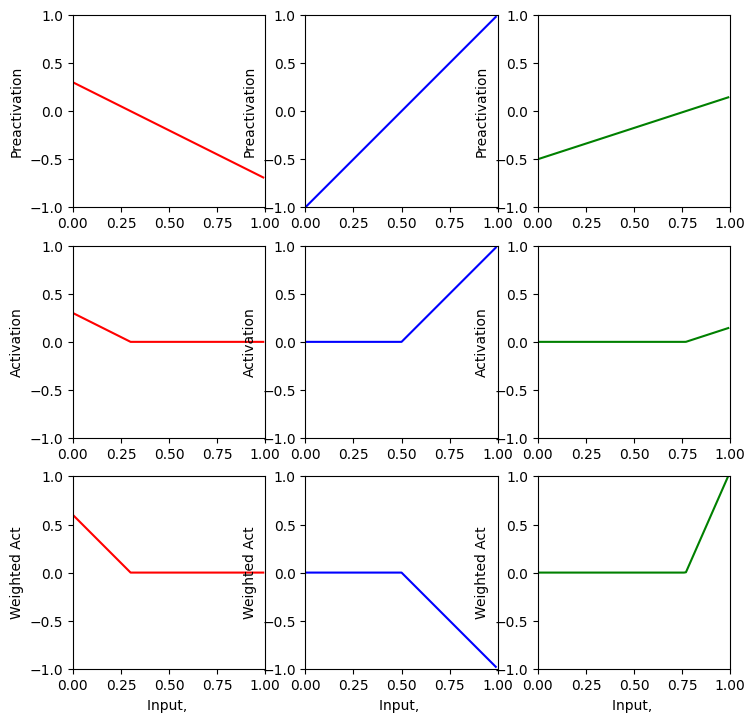

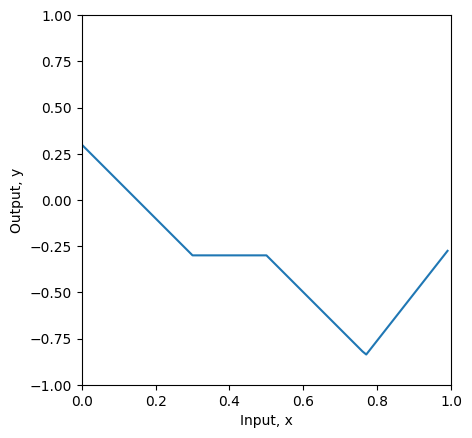

In [12]:
let x_empty = Tensor[float_type](1)
let y_empty = Tensor[float_type](1)
plot_neural[float_type](tiny, tiny_net, True, x_empty, y_empty)

In [13]:
let tiny = linear_init[float_type](0, 1, 0.01)
let theta_10: SIMD[float_type, 1] =  0.3
let theta_11: SIMD[float_type, 1] = -1.0
let theta_20: SIMD[float_type, 1] = -1.0
let theta_21: SIMD[float_type, 1] = 2.0
let theta_30: SIMD[float_type, 1] = -0.5
let theta_31: SIMD[float_type, 1] = 0.65
let phi_0: SIMD[float_type, 1] = -0.3
let phi_1: SIMD[float_type, 1] = 2.0
let phi_2: SIMD[float_type, 1] = -1.0
let phi_3: SIMD[float_type, 1] = 7.0
let tiny_net = shallow_1_1_3_full[float_type, simd_width](tiny, 
                             phi_0, phi_1, phi_2, phi_3, 
                             theta_10, theta_11, 
                             theta_20, theta_21,
                             theta_30, theta_31)

imported


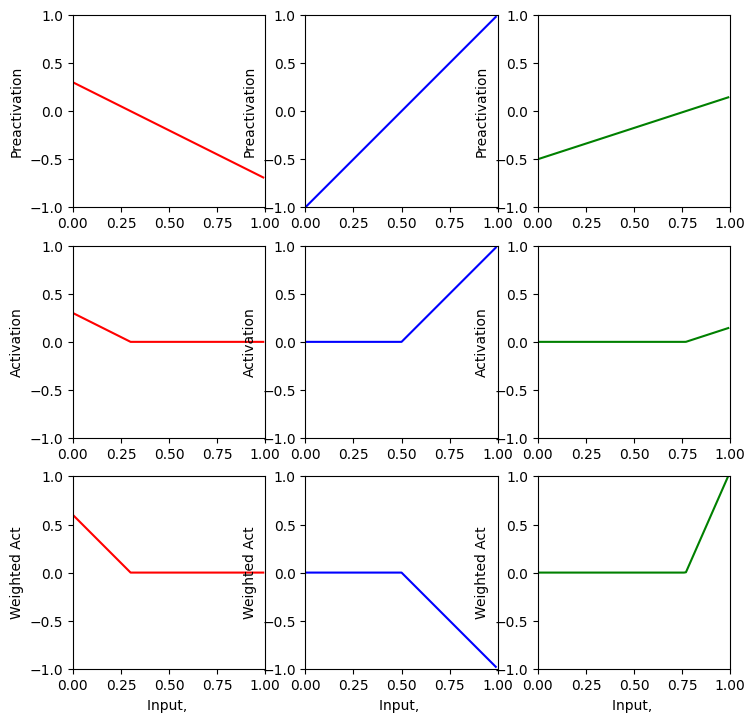

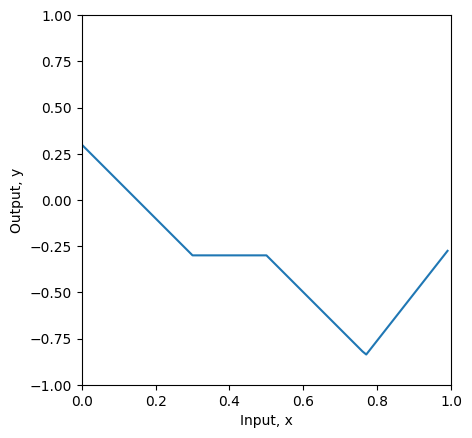

In [14]:
plot_neural[float_type](tiny, tiny_net, True, x_empty, y_empty)

In [15]:
# Define a shallow neural network with, one input, one output, and three hidden units
fn shallow_1_1_3[T: DType, width: Int](
    x: Tensor[T], 
    phi_0: SIMD[T, 1], phi_1: SIMD[T, 1], phi_2: SIMD[T, 1], phi_3: SIMD[T, 1],
    theta_10: SIMD[T,1], theta_11: SIMD[T,1], 
    theta_20: SIMD[T,1], theta_21: SIMD[T,1], 
    theta_30: SIMD[T,1], theta_31: SIMD[T,1]) raises -> Tensor[T]:

  let num = x.num_elements()

  
  # TODO Replace the lines below to compute the three initial lines
  # (figure 3.3a-c) from the theta parameters.  These are the preactivations

  let pre_1 = theta_10 + theta_11 * x
  let pre_2 = theta_20 + theta_21 * x
  let pre_3 = theta_30 + theta_31 * x

  # Pass these through the ReLU function to compute the activations as in
  # figure 3.3 d-f
  let act_1 = ReLU[T, 1](pre_1)
  let act_2 = ReLU[T, 1](pre_2)
  let act_3 = ReLU[T, 1](pre_3)

  # TODO Replace the code below to weight the activations using phi1, phi2 and phi3
  # To create the equivalent of figure 3.3 g-i
  let w_act_1 = act_1 * phi_1
  let w_act_2 = act_2 * phi_2
  let w_act_3 = act_3 * phi_3

  # TODO Replace the code below to combining the weighted activations and add
  # phi_0 to create the output as in figure 3.3 j
  let y = w_act_1 + w_act_2 + w_act_3 + phi_0

  # Return everything we have calculated
  return y

In [16]:
# Least squares function
def least_squares_loss[T: DType, width: Int](y_train: Tensor[T], 
                                             y_predict: Tensor[T]) -> SIMD[T,1]:
    let num = y_train.num_elements()
    let shape = y_train.shape()

    var loss = SIMD[T,1]()

    print(y_train)
    print(y_predict)

    for i in range(num):
        loss = loss + pow((y_train[i]-y_predict[i]),2)

    return loss

In [17]:
let x_train = Tensor[float_type](20, 0.09291784,0.46809093,0.93089486,0.67612654,0.73441752,0.86847339,\
                   0.49873225,0.51083168,0.18343972,0.99380898,0.27840809,0.38028817,\
                   0.12055708,0.56715537,0.92005746,0.77072270,0.85278176,0.05315950,\
                   0.87168699,0.58858043)
let y_train = Tensor[float_type](20, -0.15934537,0.18195445,0.451270150,0.13921448,0.09366691,0.30567674,\
                    0.372291170,0.40716968,-0.08131792,0.41187806,0.36943738,0.3994327,\
                    0.019062570,0.35820410,0.452564960,-0.0183121,0.02957665,-0.24354444, \
                    0.148038840,0.26824970)
print(x_train)
print(y_train)

Tensor([[0.092917837202548981, 0.46809092164039612, 0.93089485168457031, ..., 0.053159501403570175, 0.87168699502944946, 0.5885804295539856]], dtype=float32, shape=20)
Tensor([[-0.15934537351131439, 0.18195444345474243, 0.45127016305923462, ..., -0.24354444444179535, 0.1480388343334198, 0.26824969053268433]], dtype=float32, shape=20)


imported


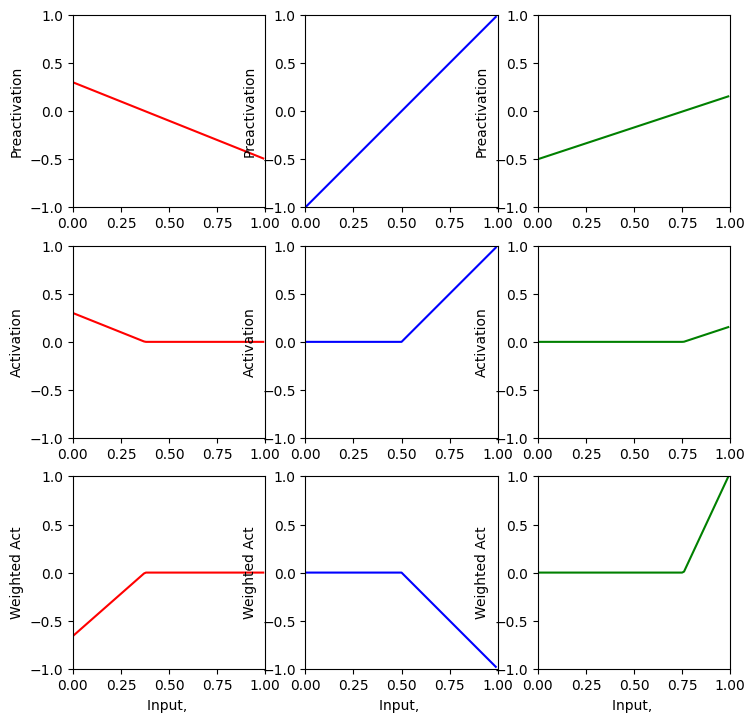


Tensor([[0.092917837202548981, 0.46809092164039612, 0.93089485168457031, ..., 0.053159501403570175, 0.87168699502944946, 0.5885804295539856]], dtype=float32, shape=20)


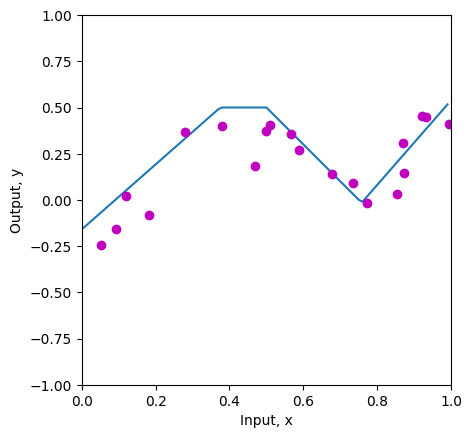

In [18]:
let theta_10: SIMD[float_type, 1] =  0.3
let theta_11: SIMD[float_type, 1] = -0.8
let theta_20: SIMD[float_type, 1] = -1.0
let theta_21: SIMD[float_type, 1] = 2.0
let theta_30: SIMD[float_type, 1] = -0.5
let theta_31: SIMD[float_type, 1] = 0.66
let phi_0: SIMD[float_type, 1] = 0.5
let phi_1: SIMD[float_type, 1] = -2.2
let phi_2: SIMD[float_type, 1] = -1.0
let phi_3: SIMD[float_type, 1] = 6.5
y_predict = shallow_1_1_3[float_type, simd_width](
                             x_train, 
                             phi_0, phi_1, phi_2, phi_3, 
                             theta_10, theta_11, 
                             theta_20, theta_21,
                             theta_30, theta_31)
let tiny_net = shallow_1_1_3_full[float_type, simd_width](tiny, 
                             phi_0, phi_1, phi_2, phi_3, 
                             theta_10, theta_11, 
                             theta_20, theta_21,
                             theta_30, theta_31)
plot_neural[float_type](tiny, tiny_net, True, x_train, y_train, True)

In [19]:
let loss = least_squares_loss[float_type, simd_width](y_predict, y_train)
print(loss)

Tensor([[0.0035353302955627441, 0.5, 0.38174927234649658, ..., -0.066439270973205566, 0.24616342782974243, 0.32283914089202881]], dtype=float32, shape=20)
Tensor([[-0.15934537351131439, 0.18195444345474243, 0.45127016305923462, ..., -0.24354444444179535, 0.1480388343334198, 0.26824969053268433]], dtype=float32, shape=20)
0.33202487230300903
